## Leveraging a pretrained model

### Feature extraction with a pretrained model

In [ ]:
#from google.colab import files
#uploaded = files.upload()

In [ ]:
!wget https://figshare.com/ndownloader/files/34178397 -O trainsmall.zip

In [ ]:
!unzip -q trainsmall.zip

In [26]:
import os, shutil

base_dir = 'E:\Flamur\data'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_brad_dir = os.path.join(train_dir, 'Brad')
train_flamur_dir = os.path.join(train_dir, 'Flamur')
train_barack_dir = os.path.join(train_dir, 'Barack')
train_dominic_dir = os.path.join(train_dir, 'Dominic')
train_jeff_dir = os.path.join(train_dir, 'Jeff')
train_rihanna_dir = os.path.join(train_dir, 'Rihanna')
train_jason_dir = os.path.join(train_dir, 'Jason')

validation_brad_dir = os.path.join(validation_dir, 'Brad')
validation_flamur_dir = os.path.join(validation_dir, 'Flamur')
validation_barack_dir = os.path.join(validation_dir, 'Barack')
validation_dominic_dir = os.path.join(validation_dir, 'Dominic')
validation_jeff_dir = os.path.join(validation_dir, 'Jeff')
validation_rihanna_dir = os.path.join(validation_dir, 'Rihanna')
validation_jason_dir = os.path.join(validation_dir, 'Jason')


test_brad_dir = os.path.join(test_dir, 'Brad')
test_flamur_dir = os.path.join(test_dir, 'Flamur')
test_barack_dir = os.path.join(test_dir, 'Barack')
test_dominic_dir = os.path.join(test_dir, 'Dominic')
test_jeff_dir = os.path.join(test_dir, 'Jeff')
test_rihanna_dir = os.path.join(test_dir, 'Rihanna')
test_jason_dir = os.path.join(test_dir, 'Jason')

In [27]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    train_dir,
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    validation_dir,
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    test_dir,
    image_size=(180, 180),
    batch_size=32)


Found 261 files belonging to 7 classes.
Found 256 files belonging to 7 classes.
Found 257 files belonging to 7 classes.


In [28]:
import os
import cv2

def remove_background(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    result = cv2.bitwise_and(image, image, mask=mask)
    return result

dataset_dir = "data"

for root, _, files in os.walk(dataset_dir):
    for file in files:
        if file.endswith(".jpg") or file.endswith(".png"):
            image_path = os.path.join(root, file)
            result = remove_background(image_path)
            cv2.imwrite(image_path, result)

**Instantiating the VGG16 convolutional base**

In [29]:
from tensorflow import keras
from tensorflow.keras import layers

conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [30]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 180, 180, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 180, 180, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 90, 90, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 90, 90, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 90, 90, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 45, 45, 128)       0     

#### Fast feature extraction without data augmentation

**Extracting the VGG16 features and corresponding labels**

In [31]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

In [32]:
train_features.shape

(261, 5, 5, 512)

Defining and training the densely connected classifier

In [33]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
#outputs = layers.Dense(1, activation="sigmoid")(x)
outputs = layers.Dense(7, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
9/9 [==============================] - 0s 16ms/step - loss: 29.4131 - accuracy: 0.4138 - val_loss: 7.5922 - val_accuracy: 0.7656
Epoch 2/20
9/9 [==============================] - 0s 6ms/step - loss: 6.0706 - accuracy: 0.8812 - val_loss: 11.2535 - val_accuracy: 0.7734
Epoch 3/20
9/9 [==============================] - 0s 7ms/step - loss: 1.2515 - accuracy: 0.9464 - val_loss: 12.2078 - val_accuracy: 0.7812
Epoch 4/20
9/9 [==============================] - 0s 5ms/step - loss: 0.6348 - accuracy: 0.9732 - val_loss: 8.0944 - val_accuracy: 0.8398
Epoch 5/20
9/9 [==============================] - 0s 5ms/step - loss: 0.2241 - accuracy: 0.9847 - val_loss: 5.7811 - val_accuracy: 0.8594
Epoch 6/20
9/9 [==============================] - 0s 6ms/step - loss: 0.8302 - accuracy: 0.9732 - val_loss: 5.8554 - val_accuracy: 0.8594
Epoch 7/20
9/9 [==============================] - 0s 5ms/step - loss: 0.0089 - accuracy: 0.9962 - val_loss: 7.0021 - val_accuracy: 0.8594
Epoch 8/20
9/9 [==============

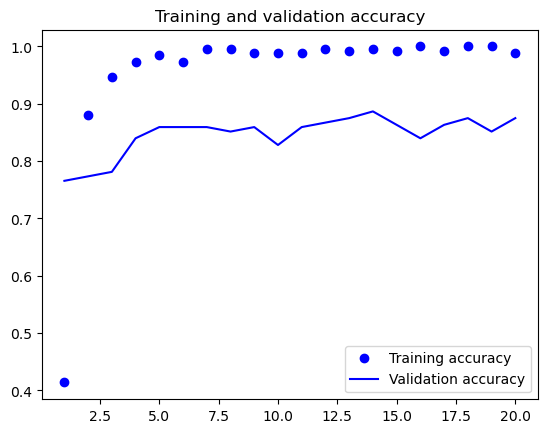

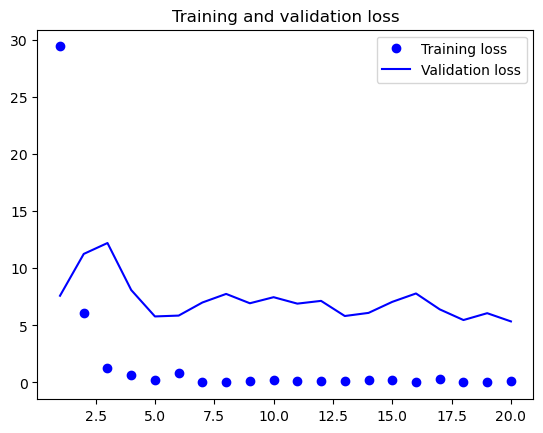

In [34]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

#### Feature extraction together with data augmentation

**Instantiating and freezing the VGG16 convolutional base**

In [35]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False   # try different pre-trained models

**Printing the list of trainable weights before and after freezing**

In [36]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [37]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


**Adding a data augmentation stage and a classifier to the convolutional base**

In [38]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(7, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer='adam',
              metrics=["accuracy"])

In [39]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
tf.__operators__.getitem_1 ( (None, 180, 180, 3)       0         
_________________________________________________________________
tf.nn.bias_add_1 (TFOpLambda (None, 180, 180, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               3277

In [40]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
9/9 [==============================] - 2s 99ms/step - loss: 25.4064 - accuracy: 0.4023 - val_loss: 13.6203 - val_accuracy: 0.6367
Epoch 2/50
9/9 [==============================] - 1s 70ms/step - loss: 14.2588 - accuracy: 0.6858 - val_loss: 11.9795 - val_accuracy: 0.7305
Epoch 3/50
9/9 [==============================] - 1s 72ms/step - loss: 7.8328 - accuracy: 0.7854 - val_loss: 11.4222 - val_accuracy: 0.7578
Epoch 4/50
9/9 [==============================] - 1s 70ms/step - loss: 6.2189 - accuracy: 0.8352 - val_loss: 9.7331 - val_accuracy: 0.8008
Epoch 5/50
9/9 [==============================] - 1s 70ms/step - loss: 7.5232 - accuracy: 0.8659 - val_loss: 8.9872 - val_accuracy: 0.8164
Epoch 6/50
9/9 [==============================] - 1s 69ms/step - loss: 4.1493 - accuracy: 0.9080 - val_loss: 10.1835 - val_accuracy: 0.7969
Epoch 7/50
9/9 [==============================] - 1s 72ms/step - loss: 3.0778 - accuracy: 0.9080 - val_loss: 12.0800 - val_accuracy: 0.7812
Epoch 8/50
9/9 [====

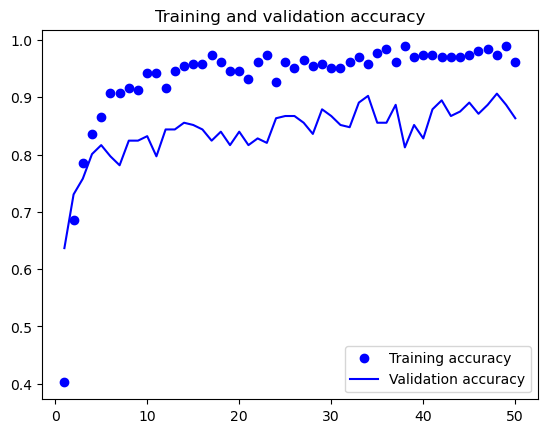

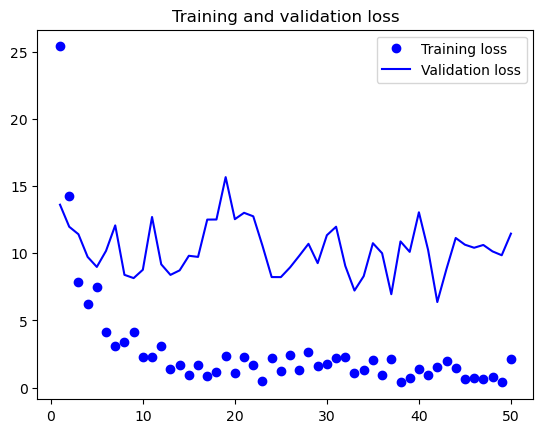

In [41]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [42]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

9/9 [==============================] - 1s 18ms/step - loss: 11.9860 - accuracy: 0.8366
Test accuracy: 0.837


### Fine-tuning a pretrained model

In [43]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

**Freezing all layers until the fourth from the last**

In [44]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [45]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

**Fine-tuning the model**

In [46]:
model.compile(
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
9/9 [==============================] - 3s 93ms/step - loss: 0.2302 - accuracy: 0.9885 - val_loss: 8.5361 - val_accuracy: 0.9102
Epoch 2/30
9/9 [==============================] - 1s 78ms/step - loss: 0.2788 - accuracy: 0.9923 - val_loss: 10.8900 - val_accuracy: 0.9062
Epoch 3/30
9/9 [==============================] - 1s 74ms/step - loss: 0.2288 - accuracy: 0.9808 - val_loss: 10.5039 - val_accuracy: 0.9180
Epoch 4/30
9/9 [==============================] - 1s 72ms/step - loss: 1.1876 - accuracy: 0.9770 - val_loss: 9.1409 - val_accuracy: 0.8984
Epoch 5/30
9/9 [==============================] - 1s 73ms/step - loss: 0.1000 - accuracy: 0.9923 - val_loss: 9.0046 - val_accuracy: 0.8984
Epoch 6/30
9/9 [==============================] - 1s 75ms/step - loss: 0.5260 - accuracy: 0.9808 - val_loss: 8.5246 - val_accuracy: 0.9180
Epoch 7/30
9/9 [==============================] - 1s 79ms/step - loss: 5.8143e-04 - accuracy: 1.0000 - val_loss: 8.5895 - val_accuracy: 0.9180
Epoch 8/30
9/9 [=====

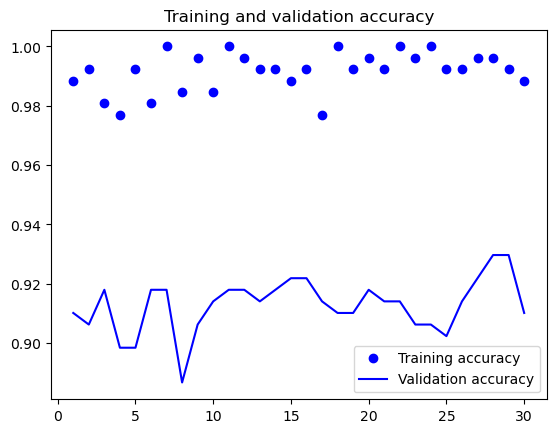

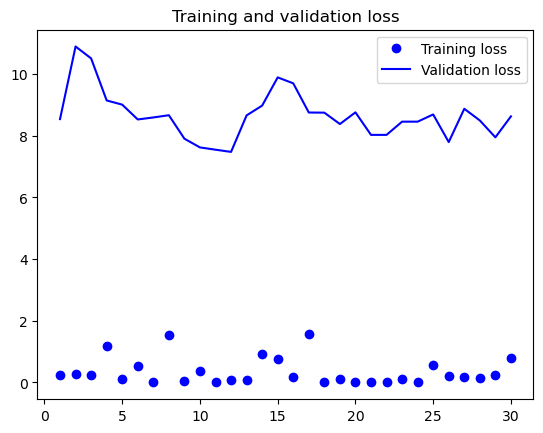

In [47]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [48]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

9/9 [==============================] - 1s 19ms/step - loss: 13.0148 - accuracy: 0.8716
Test accuracy: 0.872


In [1]:
import tkinter as tk
import cv2
import os
from PIL import Image, ImageTk
from tkinter import ttk
from datetime import datetime
from tensorflow import keras
import numpy as np
import csv

#Import the model
test_model2 = keras.models.load_model("fine_tuning.keras")

prev_name = []
predicted_class_labels = []

# Create the main window
root = tk.Tk()
root.title("Attendance Registration System")
root.geometry("900x760")

# Create a frame for the title
title_frame = tk.Frame(root)
title_frame.pack(fill="x")

# Add the title label
title_label = tk.Label(title_frame, text="Attendance Registration System", font=("Helvetica", 20))
title_label.pack(pady=10)

# Create a frame for the camera feed and table
frame = tk.Frame(root)
frame.pack(fill="both", expand=True)

# Create a label for the camera feed
camera_label = tk.Label(frame)
camera_label.grid(row=0, column=0, padx=10, pady=10, sticky="nw")

# Create a custom style for the table headings
style = ttk.Style()
style.configure("Custom.Treeview.Heading", font=("Arial", 12, "bold"))

table = ttk.Treeview(frame, columns=("Student", "Time"), show="headings", style="Custom.Treeview")
table.column("Student", width=50, anchor="center")
table.column("Time", width=50, anchor="center")
table.heading("Student", text="Student")
table.heading("Time", text="Time")
table.grid(row=0, column=1, padx=10, pady=10, sticky="nsew")

frame.grid_rowconfigure(0, weight=1)
frame.grid_columnconfigure(1, weight=1)

students_frame = tk.Frame(root)
students_frame.pack(pady=10)

#Function for registering students
def add_student(student):
    current_time = datetime.now().strftime("%H:%M")  # Get the current time
    table.insert("", "end", values=(student, current_time))    


# Function to export table data to a CSV file
def export_table():
    #Check if the table is empty
    if len(table.get_children()) == 0:
        error.config(text='Table is empty. No data to export.')
        return
    
    now = datetime.now()
    date_string = now.strftime("%d-%m-%Y")
    time_string = now.strftime("%H-%M")
    filename = f"attendance_on_{date_string}_at_{time_string}.csv"
    with open(filename, "w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Student", "Time"])  # Write the table headings
        for item in table.get_children():
            row = table.item(item)["values"]
            writer.writerow(row)
    error.config(text='CSV file exported! File name: '+filename)


    
#Click listener for the submit button
def submit():
    for label in predicted_class_labels:
        #Check if student is not registered
        if label not in prev_name:
                prev_name.append(label)
                add_student(label)
                error.config(text='')
        #If student is registered display an error message
        else:
            error.config(text='Student already registered!')

#Create submit button
submit_button = tk.Button(students_frame, text="Register Student", command=submit, font=("Arial", 14))
submit_button.pack(pady=10)

# Create export button
export_button = tk.Button(students_frame, text="Export Table", command=export_table, font=("Arial", 14))
export_button.pack(pady=10)

#Create error text label
error = tk.Label(students_frame, text="", font=("Helvetica", 16), fg="red")
error.pack(pady=10)

#Function for updating the camera feed
def update_camera_feed():
    global prev_name, predicted_class_label
    ret, frame = cap.read()
    if ret:
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        #Detecting and storing the faces in the faces[] array
        face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5, minSize=(40, 40))
        predicted_class_labels.clear()

        #Looping through each face and detecting 
        for (x, y, w, h) in faces:
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            
            #Get the name of the classes and store them in an array
            train_directory = r"E:\Flamur\data\train"
            class_names = sorted(os.listdir(train_directory))
            
            #Modify the frame to meet the requirements of the model
            resized_face = cv2.resize(gray[y:y+h, x:x+w], (180, 180))
            resized_face_rgb = cv2.cvtColor(resized_face, cv2.COLOR_GRAY2RGB)
            resized_face_rgb = resized_face_rgb.reshape((-1, 180, 180, 3))
            
            #Predict using the modified image
            prediction = test_model2.predict(resized_face_rgb)
            predicted_class_index = np.argmax(prediction)
            
            #Add the name of the class with the highest prediction to an array
            predicted_class_labels.append(class_names[predicted_class_index])

            #Display the name of the class with the highest prediction
            cv2.putText(image, class_names[predicted_class_index], (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
        
        image = Image.fromarray(image)
        image = ImageTk.PhotoImage(image)
        camera_label.config(image=image)
        camera_label.image = image

    camera_label.after(10, update_camera_feed)

cap = cv2.VideoCapture(0)

update_camera_feed()

root.mainloop()

In [7]:
cap.release()